# Geospatial demand estimation

**Original code:** [Alexandros Korkovelos](https://github.com/akorkovelos) <br />
**Support:** [Ariane Millot](https://github.com/ariane-millot), [Martin J. Stringer]() & [Vignesh Shridharan](https://github.com/vignesh1987) <br />
**Funding:** Imperial College <br />

---------------------------


#### Brief overview

This notebook performs three main analytical processes:

- **Part 1**: Generated grid mesh (H3 hexagons) for the area of interest (given input admin boundary)
- **Part 2**: Extract GIS-based attributes (vecror or raster) to the grid
- **Part 3**: Build blocks estimating demand for the different energy vectors

A slightly more detailed description of the processing bits is presented before each part below. <br />


### Import necessary modules

In [1]:
### Activate geospatial_env first

# Numeric
import numpy as np
import pandas as pd
import math

# System
import os
import shutil
from IPython.display import display, Markdown, HTML, FileLink, FileLinks

# Spatial
import geopandas as gpd
import json
import pyproj
from shapely.geometry import Point, Polygon, MultiPoint
from shapely.wkt import dumps, loads
from shapely.ops import nearest_points
from pyproj import CRS
import ogr, gdal, osr
#import fiona


# Mapping / Plotting
from functools import reduce
#import datapane as dp 
#!datapane login --token="9bde41bfbc4ad14119e32086f9f06d2e5db1d5b8"
import folium
from folium.features import GeoJsonTooltip
from folium.plugins import BeautifyIcon
from folium.plugins import HeatMap
import branca.colormap as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline

%matplotlib inline

In [2]:
#import geopandas as gpd   # Note that you require geopandas version >= 0.7 that incluse clip see here for installation (https://gis.stackexchange.com/questions/360127/geopandas-0-6-1-installed-instead-of-0-7-0-in-conda-windows-10#)
import os
import fiona
import ipywidgets as widgets
from IPython.display import display
from rasterstats import zonal_stats
import rasterio
from geojson import Feature, Point, FeatureCollection
import rasterio.fill
from shapely.geometry import shape, mapping
import json
#from earthpy import clip    clip has been deprecated to geopandas
#import earthpy.spatial as es
import numpy as np
import tkinter as tk
from tkinter import filedialog, messagebox
import gdal
import datetime
import warnings
import pandas as pd
import scipy.spatial
warnings.filterwarnings('ignore')

#import contextily as ctx
import h3 as h3
from shapely.ops import unary_union
from shapely.geometry.polygon import Polygon

root = tk.Tk()
root.withdraw()
root.attributes("-topmost", True)

pd.options.display.float_format = '{:,.4f}'.format

In [3]:
from utils import processing_raster, finalizing_rasters

### Define directories and dataset names

In [4]:
### Define directodies and dataset names

ROOT_DIR = os.path.abspath(os.curdir)
in_path = ROOT_DIR
out_path = ROOT_DIR + "/Outputs"

## admininstrative boundary
admin_path = in_path + "\\"+ 'admin'
admin_name = "Copperbelt.gpkg"
adm_col_name = "ADM1_NAME"          ## Provide the name of the column you want to use to clip the hexagons e.g., "NAME" or "ADM1_NAME"

## mines layer
mines_path = in_path + "/Industry/Data/mines"
mines_name = 'mines_zambia.gpkg'

## RWI layer
rwi_path = in_path + "/Residential/Data/rwi"
rwi_name = 'zmb_relative_wealth_index.csv'

In [5]:
## Coordinate and projection systems
crs_WGS84 = CRS("EPSG:4326")    # Originan WGS84 coordinate system
crs_proj = CRS("EPSG:32736")    # Projection system for the selected country -- see http://epsg.io/ for more info

### Import layers to be used

In [6]:
## admininstrative boundary
admin_gdf = gpd.read_file(admin_path + "/" + admin_name)

## mines
mines = gpd.read_file(mines_path + "/" + mines_name)

## Import Relative Wealth Index | convert to geodf | export as gpkg
rwi = pd.read_csv(rwi_path + "/" + rwi_name)
rwi_gdf = gpd.GeoDataFrame(rwi, geometry=gpd.points_from_xy(rwi.longitude, rwi.latitude), crs={'init': 'epsg:4326'})
rwi_gdf.to_file(os.path.join(rwi_path,"{c}".format(c=rwi_name.split(".")[0])), driver="GPKG")

# Part 1. Create base grid with H3

### H3 - Hegagon - grid

In [7]:
# Make a copy of the original dataframe (as it might require some changes)
admin_gdf_copy_2 = admin_gdf.buffer(1.245)     ## this is ~15km --> 0.83*1.5

In [8]:
## No of multipolygons in the geometry
#check_geom_type = admin_gdf_copy.geometry.apply(lambda x: list(x))[0]

#len(check_geom_type)

It seems that the geometry is not a polygon but multipolygon. That is, the h3.polyfill will not work. In case the original layer consists of many parts then you shall follow a "merging" approach using a small buffer as described [here](https://gis.stackexchange.com/questions/311931/geopandas-equivalent-of-st-makepolygon/312004#312004). 

However, if polygons are not close this will not work. Thus, the following process (which I do only for one of them) needs to be done for each polygon separately -- unless you write some code to do this automatically! :)

In [9]:
#polygon = check_geom_type[0]
#polygon

In [10]:
#combined = [unary_union(polygon)]
#admin_gdf_copy.geometry = combined

In [11]:
# Convert this to geojson
gj = gpd.GeoSeries([admin_gdf_copy_2.geometry[0]]).__geo_interface__
geoJson = gj['features'][0]['geometry']

In [12]:
size = 7 ## resolution info here https://h3geo.org/docs/core-library/restable
hexagons = pd.DataFrame(h3.polyfill(geoJson, size), columns=['hexagons'])
hexagons.head()

hexagons
0  875535275ffffff
1  875534601ffffff
2  87553064effffff
3  875534082ffffff
4  875536201ffffff

In [13]:
hexagons['geometry'] = hexagons.hexagons.apply(lambda hex: Polygon(h3.h3_to_geo_boundary(hex)))
hexagons['centeroid'] = hexagons.hexagons.apply(lambda hex: h3.h3_to_geo(hex))

crs = {'init': 'epsg:4326'}

hexagons = gpd.GeoDataFrame(hexagons, crs=crs, geometry=hexagons.geometry)
hexagons['lon'] = hexagons['centeroid'].apply(lambda x: x[0])
hexagons['lat'] = hexagons['centeroid'].apply(lambda x: x[1])

hexagons = hexagons.drop(['centeroid'], axis=1)

display(hexagons.head())

hexagons                                           geometry     lon  \
0  875535275ffffff  POLYGON ((26.71773 -11.46952, 26.70782 -11.479... 26.7050   
1  875534601ffffff  POLYGON ((27.51345 -12.97310, 27.50337 -12.983... 27.5007   
2  87553064effffff  POLYGON ((26.26672 -13.12805, 26.25665 -13.138... 26.2541   
3  875534082ffffff  POLYGON ((27.84140 -12.93556, 27.83132 -12.945... 27.8286   
4  875536201ffffff  POLYGON ((27.14418 -13.70934, 27.13404 -13.719... 27.1314   

       lat  
0 -11.4654  
1 -12.9687  
2 -13.1237  
3 -12.9311  
4 -13.7048

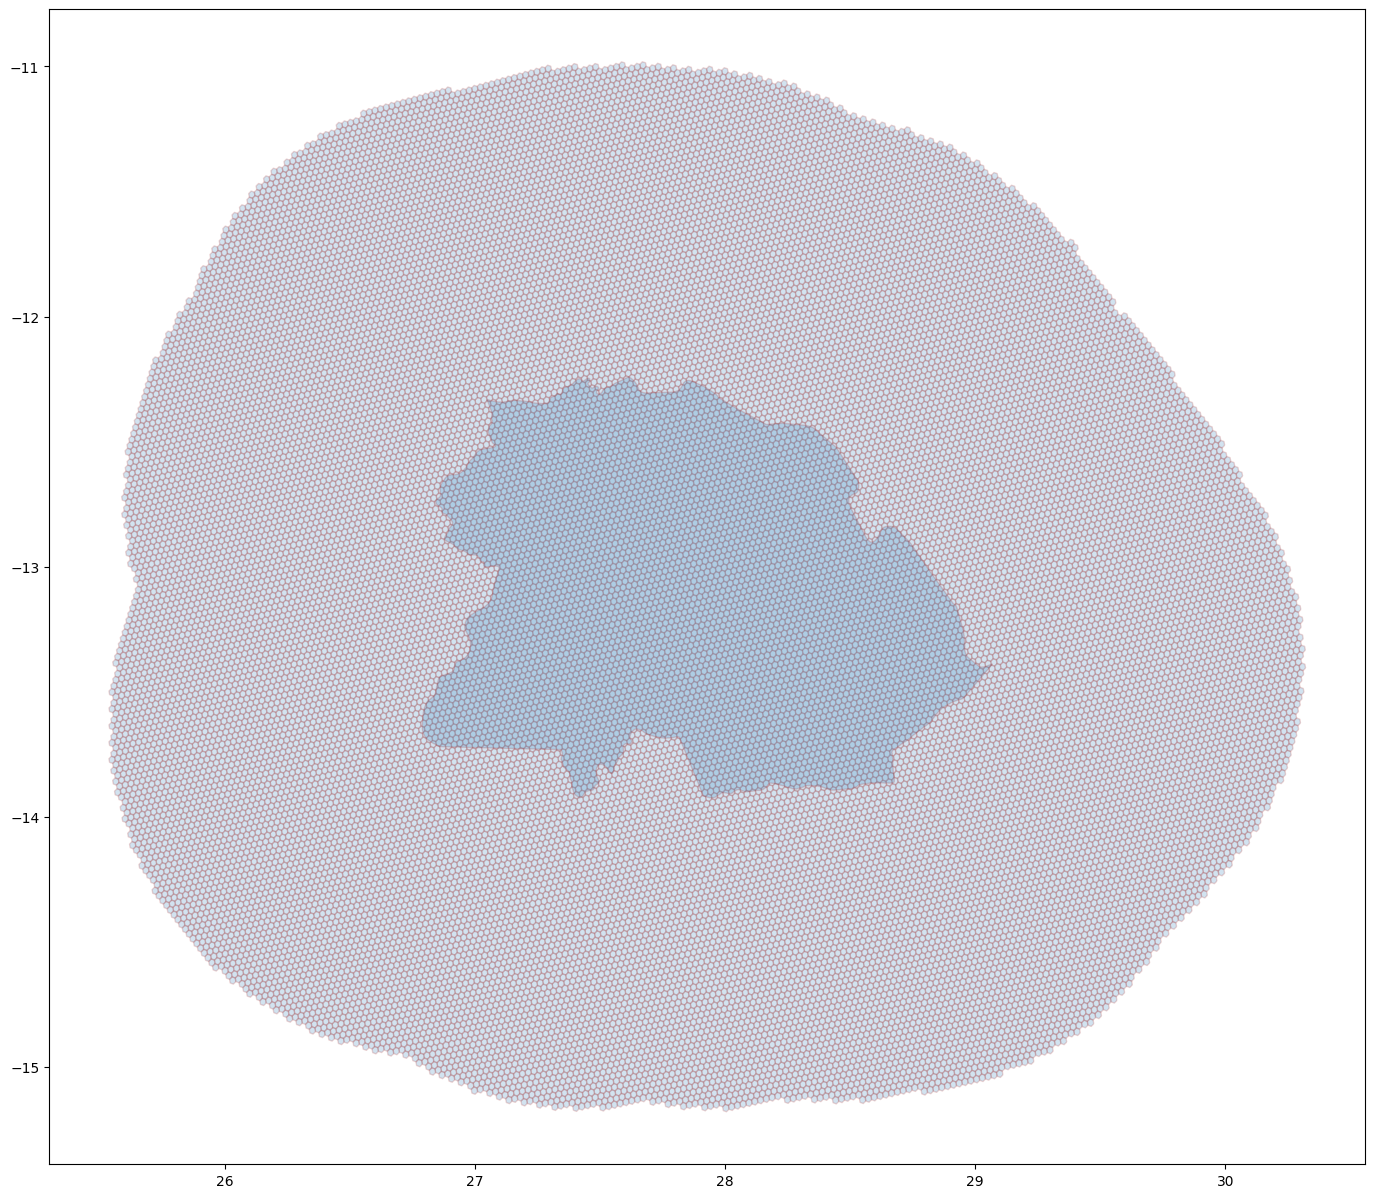

In [14]:
# Plot fishnet & basemap
fig, ax = plt.subplots(figsize=(25, 15))
hexagons.plot(ax=ax, edgecolor='brown', alpha=0.2)
admin_gdf.plot(ax=ax, edgecolor='brown', alpha=0.2)
ax.set_aspect('equal', 'box')

# Save plot as figure 
#plt.savefig('admin level basemap.png', bbox_inches='tight')

In [15]:
#Clipping to the borders of the admin area
join_left_df = gpd.sjoin(hexagons, admin_gdf[[adm_col_name, "geometry"]], how="left")
hexagons = join_left_df[join_left_df[adm_col_name].notnull()]

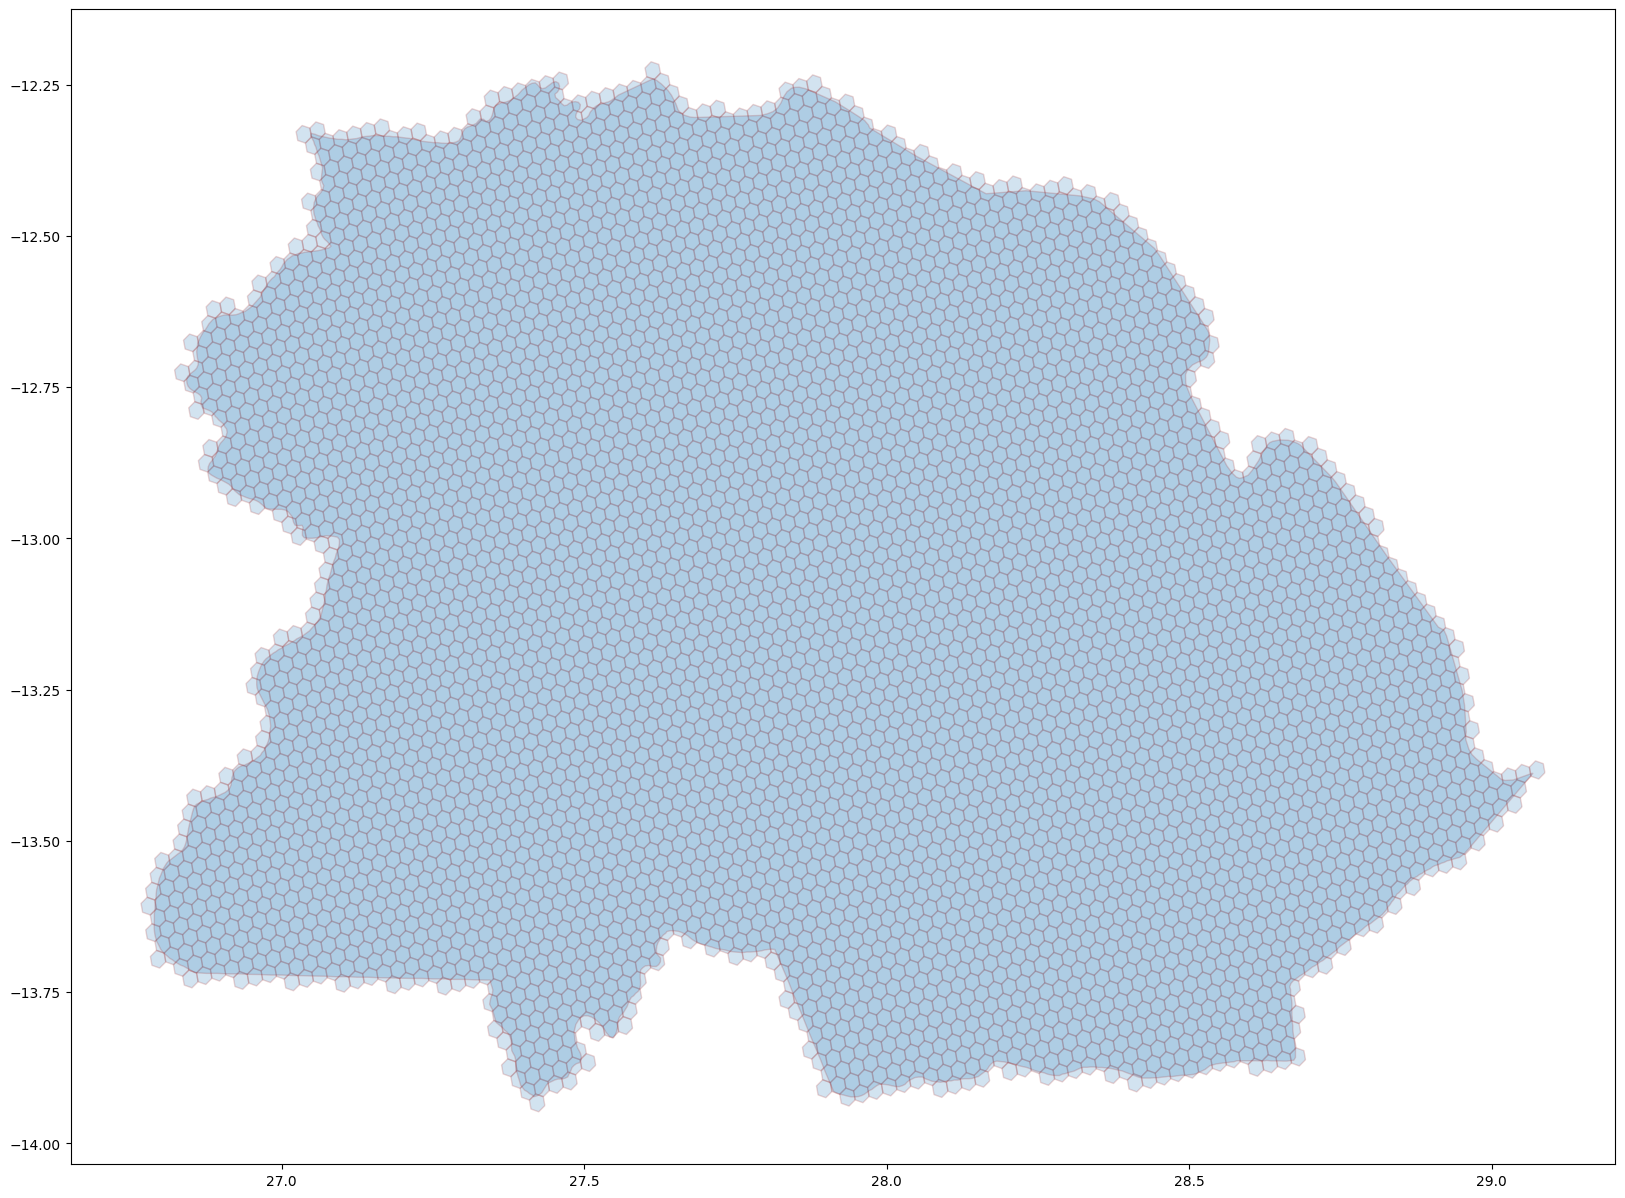

In [16]:
# Plot fishnet & basemap
fig, ax = plt.subplots(figsize=(25, 15))
hexagons.plot(ax=ax, edgecolor='brown', alpha=0.2)
admin_gdf.plot(ax=ax, edgecolor='brown', alpha=0.2)
ax.set_aspect('equal', 'box')

# Save plot as figure 
#plt.savefig('admin level basemap.png', bbox_inches='tight')

In [17]:
# Export dataframe to csv or gpkg
#hexagons.to_csv(out_path + "\\" + f'h3_grid_at_hex_{size}.csv', index=False)
hexagons.to_file(out_path + "\\" + f'h3_grid_at_hex_{size}.shp', index=False)
# with fiona.Env(OSR_WKT_FORMAT="WKT2_2018"):
#     hexagons.to_file(out_path + "\\" + f'h3_grid_at_hex_{size}.shp', index=False, engine='fiona')
# hexagons.to_file(out_path + "\\" + f'h3_grid_at_hex_{size}.shp', index=False, engine='pyogrio')

# Part 2. Extract GIS-based attributes

#### Select base map grid and proceed with processing

In [18]:
#hexagons = gpd.read_file(outpath + "\\" + "hex6_with_neighbors.geojson")

In [19]:
grid = hexagons

In [20]:
grid['id'] = range(1, len(grid)+1)

In [21]:
grid.head(3)

hexagons                                           geometry     lon  \
1  875534601ffffff  POLYGON ((27.51345 -12.97310, 27.50337 -12.983... 27.5007   
3  875534082ffffff  POLYGON ((27.84140 -12.93556, 27.83132 -12.945... 27.8286   
4  875536201ffffff  POLYGON ((27.14418 -13.70934, 27.13404 -13.719... 27.1314   

       lat  index_right   ADM1_NAME  id  
1 -12.9687       0.0000  COPPERBELT   1  
3 -12.9311       0.0000  COPPERBELT   2  
4 -13.7048       0.0000  COPPERBELT   3

### Define extraction functions

In [22]:
def spatialjoinvectors(name, column, admin, crs, clusters, val):
    messagebox.showinfo('DemandMapping', 'Select the ' + name + ' map')
    # points=gpd.read_file(filedialog.askopenfilename(filetypes = (("shapefile","*.shp"),("all files","*.*"))))
    points=gpd.read_file(filedialog.askopenfilename(filetypes = (("all files","*.*"),)))
    points.head(5)
    
    points_clip = gpd.clip(points, admin)
    points_clip.crs = {'init' :'epsg:4326'}
    points_proj=points_clip.to_crs({ 'init': crs})
    if 'Mines' in name:
        points_proj[column] = points_proj[column].str.replace(',', '')
        points_proj[column] = points_proj[column].astype(float)     ## added so that the sample mining productions works; you may need to update this as per layer used
    
    gdf_points = points_proj[[column, "geometry"]]
    pointsInPolygon = gpd.sjoin(gdf_points, clusters, how="inner", op='within')
    ## Defining operation on the selected data
    if val=="sum":
        group_by_name = pointsInPolygon[["id", column]].groupby(["id"]).sum().reset_index()
    elif val=="mean":
        group_by_name = pointsInPolygon[["id", column]].groupby(["id"]).mean().reset_index()
    clusters = pd.merge(clusters, group_by_name[['id', column]], on='id', how = 'left')
    
    return clusters

## Extract raster values to hexagons

Extract count of buildings per hex

In [23]:
pathWorldPopBuiCount = "Residential/Data/WorldPop/Copperbelt_buildings_v2_0_count.tif"
grid = processing_raster("buildings", "count", grid, filepath=pathWorldPopBuiCount)      #Copperbelt_buildings_v2_0_count from https://apps.worldpop.org/peanutButter/

2023-07-16 18:38:53.408863


Extract lighing data

In [24]:
## set_lightscore_sy_xxxx.tif: Predicted likelihood that a settlement is electrified (0 to 1)
## http://www-personal.umich.edu/~brianmin/HREA/data.html
pathHREA = "Residential/Data/Lighting/HREA_Zambia_2019_v1/Zambia_set_lightscore_sy_2019.tif"
grid = processing_raster("HREA", "mean", grid, filepath=pathHREA)
columnProbElec= "HREA"

2023-07-16 18:41:04.573365


#### ..You can extract values from other raster layers here too..

##### Once done with rasters run this cell

In [25]:
grid = finalizing_rasters(out_path, grid, crs_proj)

2023-07-16 18:41:05.877635


In [26]:
grid.drop(['index_right'], axis=1, inplace=True)
grid.head(4)

hexagons     lon      lat   ADM1_NAME  id  buildingscount  HREAmean  \
0  875534601ffffff 27.5007 -12.9687  COPPERBELT   1              26    0.0615   
1  875534082ffffff 27.8286 -12.9311  COPPERBELT   2              39    0.3425   
2  875536201ffffff 27.1314 -13.7048  COPPERBELT   3               0    0.0382   
3  8734692a3ffffff 28.2478 -13.5905  COPPERBELT   4              16    0.0886   

                                            geometry  
0  POLYGON ((27.51345 -12.97310, 27.50337 -12.983...  
1  POLYGON ((27.84140 -12.93556, 27.83132 -12.945...  
2  POLYGON ((27.14418 -13.70934, 27.13404 -13.719...  
3  POLYGON ((28.26063 -13.59505, 28.25048 -13.605...

## Extract information from vector layers

Extract sum production of mines in each cluster (hex)

In [27]:
## Run the extraction
#grid.drop(['Commodity Production - tonne (tonnes)'], axis=1, inplace=True) ##uncomment if you want to rerun
# columnNameMines = "Commodity Production - tonne (tonnes)"
columnNameMines = 'Ore processed (tonnes)'
grid = spatialjoinvectors("Mines", columnNameMines, admin_gdf, crs_WGS84, grid, "sum")
grid[columnNameMines] = grid[columnNameMines].fillna(0)
grid.head(4)

hexagons     lon      lat   ADM1_NAME  id  buildingscount  HREAmean  \
0  875534601ffffff 27.5007 -12.9687  COPPERBELT   1              26    0.0615   
1  875534082ffffff 27.8286 -12.9311  COPPERBELT   2              39    0.3425   
2  875536201ffffff 27.1314 -13.7048  COPPERBELT   3               0    0.0382   
3  8734692a3ffffff 28.2478 -13.5905  COPPERBELT   4              16    0.0886   

                                            geometry  Ore processed (tonnes)  
0  POLYGON ((27.51345 -12.97310, 27.50337 -12.983...                  0.0000  
1  POLYGON ((27.84140 -12.93556, 27.83132 -12.945...                  0.0000  
2  POLYGON ((27.14418 -13.70934, 27.13404 -13.719...                  0.0000  
3  POLYGON ((28.26063 -13.59505, 28.25048 -13.605...                  0.0000

In [28]:
grid[columnNameMines].sum()

24359691.0

Extract wealth data from RWI

In [29]:
## Run the extraction
#grid.drop(['rwi'], axis=1, inplace=True) ##uncomment if you want to rerun
columnNameRWI = "rwi"
grid = spatialjoinvectors("RWI", columnNameRWI, admin_gdf, crs_WGS84, grid, 'mean')
averageRwi = grid[columnNameRWI].mean()
print(averageRwi)
grid[columnNameRWI] = grid[columnNameRWI].fillna(averageRwi)

-0.23528880111524164


In [30]:
grid.rename({'HREAmean': 'HREA'}, axis=1, inplace=True)

# Part 3. Constructing Multi-vector Demand

### Industry

In [31]:
grid.head(3)

hexagons     lon      lat   ADM1_NAME  id  buildingscount   HREA  \
0  875534601ffffff 27.5007 -12.9687  COPPERBELT   1              26 0.0615   
1  875534082ffffff 27.8286 -12.9311  COPPERBELT   2              39 0.3425   
2  875536201ffffff 27.1314 -13.7048  COPPERBELT   3               0 0.0382   

                                            geometry  Ore processed (tonnes)  \
0  POLYGON ((27.51345 -12.97310, 27.50337 -12.983...                  0.0000   
1  POLYGON ((27.84140 -12.93556, 27.83132 -12.945...                  0.0000   
2  POLYGON ((27.14418 -13.70934, 27.13404 -13.719...                  0.0000   

      rwi  
0 -0.5350  
1 -0.7090  
2 -0.2353

In [32]:
#Assess total energy consumption and total production
elec_nonFerrousMetals = 22897 #PJ
elec_nonFerrousMetals = elec_nonFerrousMetals / (3.6e-6) #conversion en MWh
total_production = sum(grid[columnNameMines])
print(f"{total_production:,.0f}")
print(f"{elec_nonFerrousMetals:,.0f}")
print("energy per tonne of ore:", f"{elec_nonFerrousMetals/total_production:,.0f}", "MWh/t")

24,359,691
6,360,277,778
energy per tonne of ore: 261 MWh/t


In [33]:
#Allocate to each hexagon the industry energy consumption
grid["IndustryEnergy"]=grid[columnNameMines]/total_production * elec_nonFerrousMetals
grid.head(3)
total_industryenergy = grid["IndustryEnergy"].sum()
print(f"{total_industryenergy:,.0f}") #kWh

6,360,277,778


In [34]:
grid.head(3)

hexagons     lon      lat   ADM1_NAME  id  buildingscount   HREA  \
0  875534601ffffff 27.5007 -12.9687  COPPERBELT   1              26 0.0615   
1  875534082ffffff 27.8286 -12.9311  COPPERBELT   2              39 0.3425   
2  875536201ffffff 27.1314 -13.7048  COPPERBELT   3               0 0.0382   

                                            geometry  Ore processed (tonnes)  \
0  POLYGON ((27.51345 -12.97310, 27.50337 -12.983...                  0.0000   
1  POLYGON ((27.84140 -12.93556, 27.83132 -12.945...                  0.0000   
2  POLYGON ((27.14418 -13.70934, 27.13404 -13.719...                  0.0000   

      rwi  IndustryEnergy  
0 -0.5350          0.0000  
1 -0.7090          0.0000  
2 -0.2353          0.0000

### Residential

In [35]:
# Retrieve values from the MTF survey
ROOT_DIR = os.path.abspath(os.curdir)
%run Residential/energy_demand_res.ipynb
energyConsHH = energycons_res_mtf["annual"] # dictionnary for each region one value
energyConsHH

Electricity consumption : 4,022,500,000 MWh
Electricity consumption : 4,022 TWh


CENTRAL         1,558
COPPERBELT      3,093
EASTERN         1,260
LUAPULA         2,630
LUSAKA          2,982
NORTH WESTERN   2,172
SOUTHERN        1,742
WESTERN           288
TOTAL           2,710
Name: annual, dtype: float64

In [54]:
# electrified or non-electrified status
grid["Status_electrified"] = grid.apply(lambda row: ("elec" if ((row[columnProbElec] > 0))
                                             else "nonelec"), axis=1)
grid["Status_electrified"].value_counts()

Status_electrified
elec       4471
nonelec     695
Name: count, dtype: int64

In [37]:
# for each hexagon, determine if it's rural or urban --> to change!
grid["Location"] = grid.apply(lambda row: ("rural" if ((row['buildingscount'] < 100))
                                             else "urban"), axis=1)

In [56]:
# for each hexagon, assessment of the number of HH
# shareResBuildings = {"urban": 0.60, "rural": 0.99} # --> to change!
shareResBuildings = {"urban": 1, "rural": 1} # --> to change!
elec = {"elec": 0, "nonelec": 1}
# sizeHH = {"urban": 4.7, "rural": 5.2} #https://population.un.org/Household/index.html#/countries/ https://dhsprogram.com/publications/publication-fr361-dhs-final-reports.cfm
#print(grid["Location"].map(shareResBuildings))
grid["ResHHNbWithAccess"]=grid["buildingscount"]*grid["Location"].map(shareResBuildings)*grid["Status_electrified"].map(elec)
print(grid["ResHHNbWithAccess"].sum())
grid.head(4)

708


hexagons  lon  lat   ADM1_NAME  id  buildingscount  HREA  \
0  875534601ffffff   28  -13  COPPERBELT   1              26     0   
1  875534082ffffff   28  -13  COPPERBELT   2              39     0   
2  875536201ffffff   27  -14  COPPERBELT   3               0     0   
3  8734692a3ffffff   28  -14  COPPERBELT   4              16     0   

                                            geometry  Ore processed (tonnes)  \
0  POLYGON ((27.51345 -12.97310, 27.50337 -12.983...                       0   
1  POLYGON ((27.84140 -12.93556, 27.83132 -12.945...                       0   
2  POLYGON ((27.14418 -13.70934, 27.13404 -13.719...                       0   
3  POLYGON ((28.26063 -13.59505, 28.25048 -13.605...                       0   

   rwi  IndustryEnergy Status_electrified Location  ResHHNoWithAccess  \
0   -1               0               elec    rural                  0   
1   -1               0               elec    rural                  0   
2   -0               0               elec    rural                  0   
3   -0               0               elec    rural                  0   

   ResidentialEnergyCorrPerHH  ResidentialEnergy  Residential  Commercial  \
0                       7,033                  0            0        2600   
1                       9,320                  0            0        3900   
2                       3,093                  0            0           0   
3                       3,093                  0            0        1600   

   TotalDem  ResHHNbWithAccess  
0     2,600                  0  
1     3,900                  0  
2         0                  0  
3     1,600                  0

In [39]:
adm = grid["ADM1_NAME"].unique()
print (adm)

['COPPERBELT']


In [57]:
# Energy Consumption assessment per cell
averageRwi = grid['rwi'].mean()
grid["ResidentialEnergyCorrPerHH"] = grid['rwi']/averageRwi*grid["ADM1_NAME"].map(energyConsHH)
grid["ResidentialEnergy"] = grid["ResHHNbWithAccess"] * grid["ResidentialEnergyCorrPerHH"] * (grid["Status_electrified"]!="nonelec")
grid.head(3)

hexagons  lon  lat   ADM1_NAME  id  buildingscount  HREA  \
0  875534601ffffff   28  -13  COPPERBELT   1              26     0   
1  875534082ffffff   28  -13  COPPERBELT   2              39     0   
2  875536201ffffff   27  -14  COPPERBELT   3               0     0   

                                            geometry  Ore processed (tonnes)  \
0  POLYGON ((27.51345 -12.97310, 27.50337 -12.983...                       0   
1  POLYGON ((27.84140 -12.93556, 27.83132 -12.945...                       0   
2  POLYGON ((27.14418 -13.70934, 27.13404 -13.719...                       0   

   rwi  IndustryEnergy Status_electrified Location  ResHHNoWithAccess  \
0   -1               0               elec    rural                  0   
1   -1               0               elec    rural                  0   
2   -0               0               elec    rural                  0   

   ResidentialEnergyCorrPerHH  ResidentialEnergy  Residential  Commercial  \
0                       7,033                  0            0        2600   
1                       9,320                  0            0        3900   
2                       3,093                  0            0           0   

   TotalDem  ResHHNbWithAccess  
0     2,600                  0  
1     3,900                  0  
2         0                  0

### Calculate Total Demand

**Demand = Residential + Commercial + Industrial (only an EXAMPLE)**

where, 

**Residential** = No of buildings X 50 kWh/building/year  

**Commercial**  = (No of buildings X 20 kWh/bld/year) if more than 100 buildings else (No of buildings X 100 kWh/bld/year)

**Industrial**  = Commodity Production - tonne (tonnes) from mines

In [58]:
# grid["Residential"] = grid.apply(lambda row: (row['buildingscount']*200), axis=1)
grid["Residential"]= grid["ResidentialEnergy"]
total_residentialenergy_assessed = grid["Residential"].sum()
print(f"{total_residentialenergy_assessed:,.0f}") #kWh

0


In [42]:
grid["Commercial"] = grid.apply(lambda row: (row['buildingscount']*50 if ((row['buildingscount'] > 100))
                                             else row['buildingscount']*100), axis=1)
total_servicesenergy_assessed = grid["Commercial"].sum()
print(f"{total_servicesenergy_assessed:,.0f}") #kWh

16,752,300


In [43]:
grid["TotalDem"] = grid.apply(lambda row: (row['Residential'] + 
                                          row['Commercial']  
                                          # +row["IndustryEnergy"]
                                          ), axis=1)

In [44]:
total = grid.TotalDem.sum()
print(f"{total:,.0f}") #kWh

16,752,300


In [45]:
grid.head(3)

hexagons  lon  lat   ADM1_NAME  id  buildingscount  HREA  \
0  875534601ffffff   28  -13  COPPERBELT   1              26     0   
1  875534082ffffff   28  -13  COPPERBELT   2              39     0   
2  875536201ffffff   27  -14  COPPERBELT   3               0     0   

                                            geometry  Ore processed (tonnes)  \
0  POLYGON ((27.51345 -12.97310, 27.50337 -12.983...                       0   
1  POLYGON ((27.84140 -12.93556, 27.83132 -12.945...                       0   
2  POLYGON ((27.14418 -13.70934, 27.13404 -13.719...                       0   

   rwi  IndustryEnergy Status_electrified Location  ResHHNoWithAccess  \
0   -1               0               elec    rural                  0   
1   -1               0               elec    rural                  0   
2   -0               0               elec    rural                  0   

   ResidentialEnergyCorrPerHH  ResidentialEnergy  Residential  Commercial  \
0                       7,033                  0            0        2600   
1                       9,320                  0            0        3900   
2                       3,093                  0            0           0   

   TotalDem  
0     2,600  
1     3,900  
2         0

### Export result

In [46]:
crs_WGS84 = CRS("EPSG:4326")    # Originan WGS84 coordinate system
grid = grid.to_crs({ 'init': crs_WGS84}) 

In [47]:
with fiona.Env(OSR_WKT_FORMAT="WKT2_2018"):
    grid.to_file(out_path + "\\" + 'total_demand_grid.gpkg', driver="GPKG", index=False, engine='fiona')
#grid.to_file(out_path + "\\" + 'total_demand_grid.geojson', driver="GeoJSON")

## Print maps for quick assessment

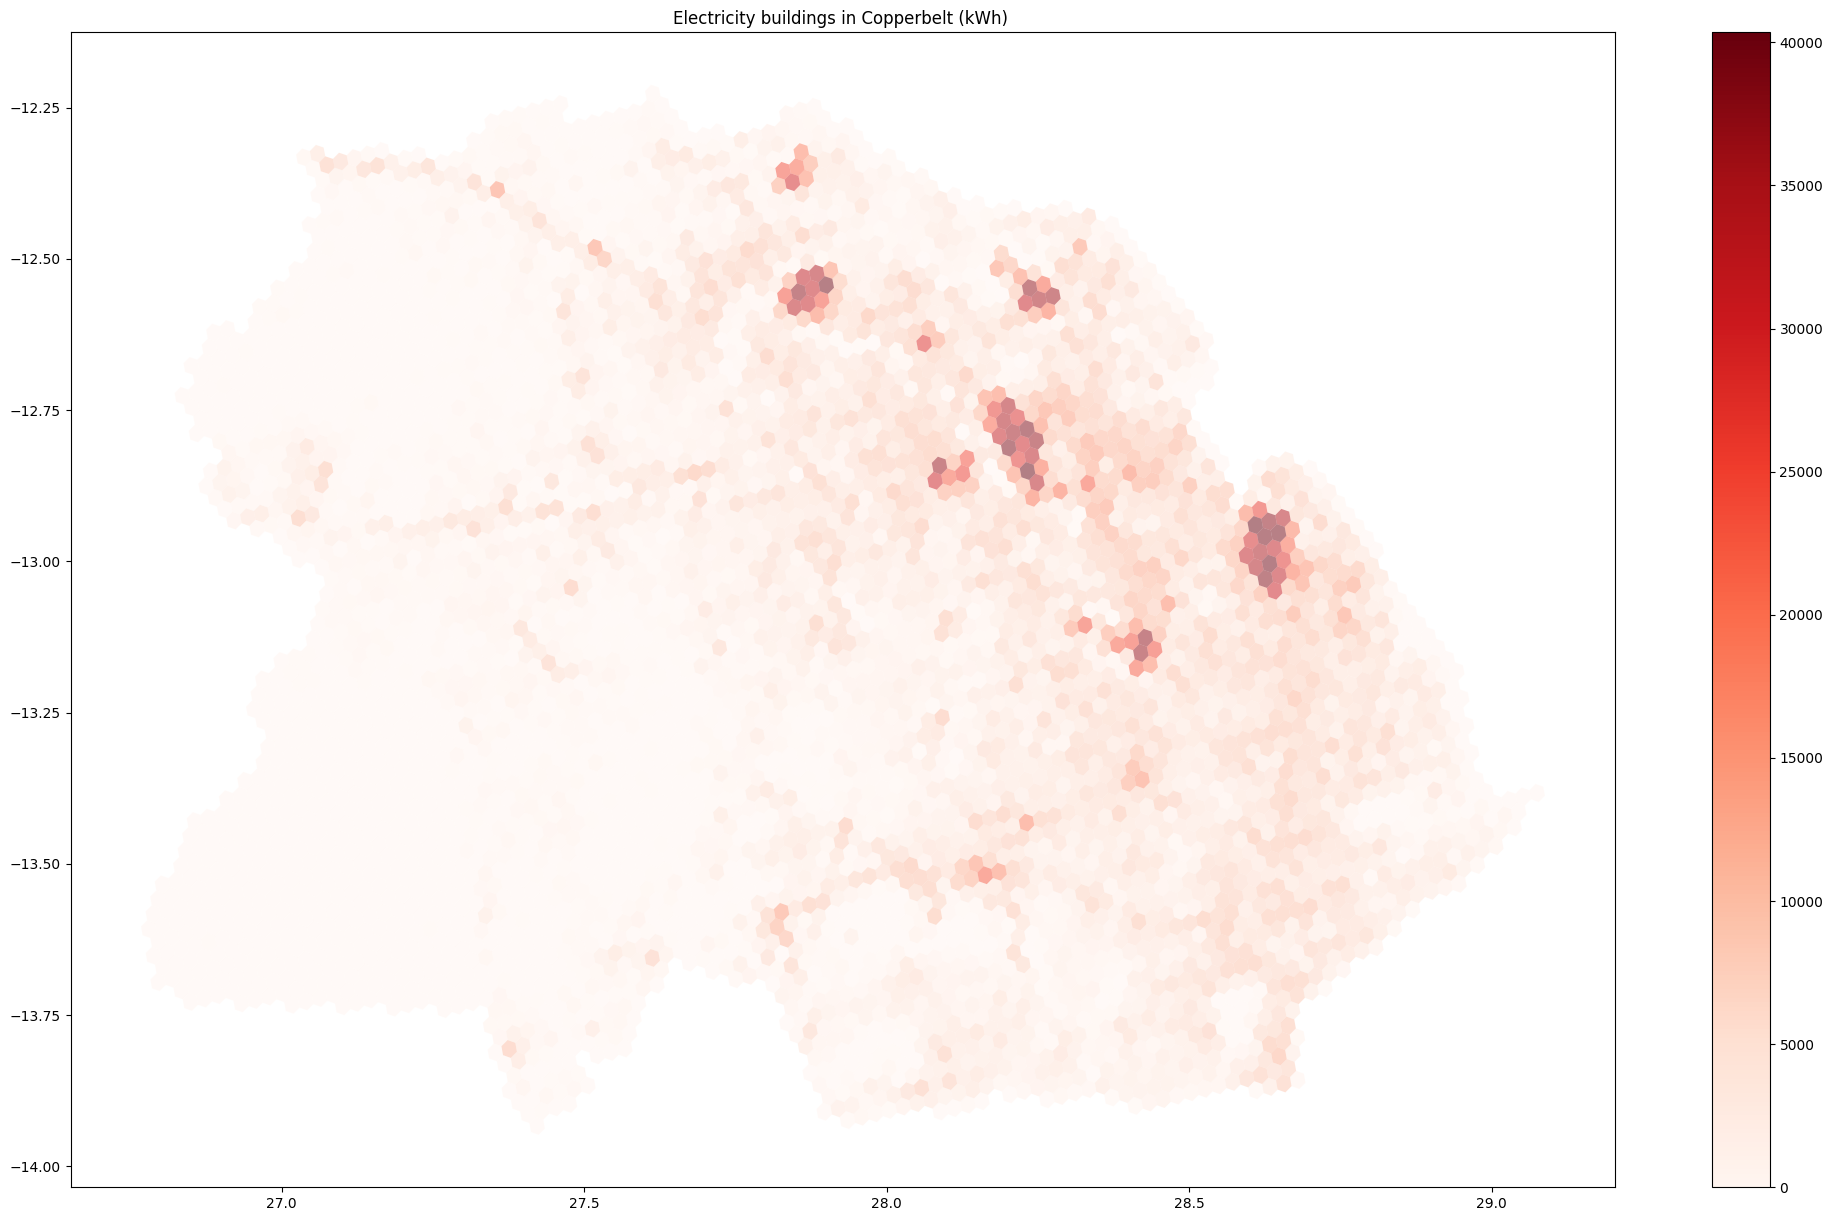

In [48]:
# Plotting for testinf
# Create the axis first
fig, ax = plt.subplots(figsize=(25, 15))

# Plot all crops
grid.sort_values('TotalDem', ascending=True).plot(
    ax=ax, column='TotalDem', cmap="Reds", legend=True, alpha=0.5)

ax.set_aspect('equal', 'box')
txt = ax.set_title('Electricity buildings in {} '.format("Copperbelt (kWh)") )

# Save plot as figure 
plt.savefig('sample_priority_map.png', bbox_inches='tight')